# Growth rate of cases
Computing exponential growth rate of number of cases and visualize, comparing with DOW index

Read from data
https://covidtracking.com/api/v1/states/daily.csv
https://finance.yahoo.com/quote/%5EDJI/history/

In [1]:
import pandas as pd

dowDf = pd.read_csv("^DJI.csv")
covidDf = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")

Cleaning/Compute Number of days

In [2]:
import datetime

day0 = datetime.date(2020, 1, 15)
covidDf['dateChecked'] = pd.to_datetime(covidDf['dateChecked']).dt.date
covidDf['day'] = (covidDf['dateChecked'] - day0).dt.days
dowDf['Date'] = pd.to_datetime(dowDf['Date']).dt.date
dowDf['Day'] = (dowDf['Date'] - day0).dt.days

Interpolating Dow index and plot with COVID data

<ipython-input-3-67b00ffa1722>:35: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(loc=0)


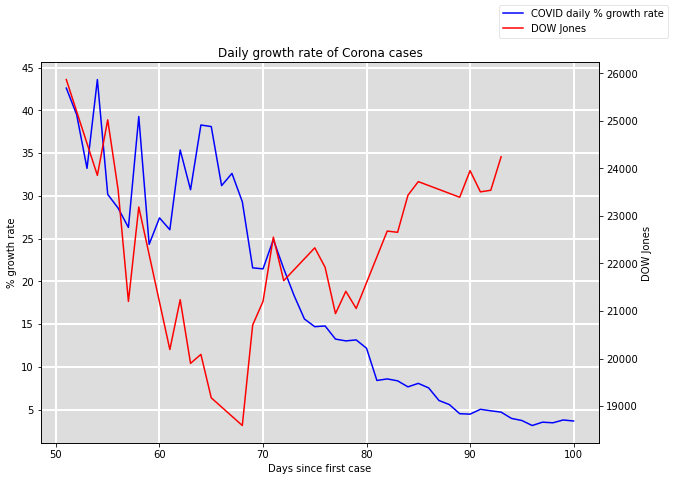

In [3]:
import matplotlib.pyplot as plt
import pandasql as ps
from scipy import interpolate


# Sum all states
covidDf = covidDf
sumDf = ps.sqldf("SELECT day, SUM(positive) as cases FROM covidDf GROUP BY dateChecked")
# Compute daily increases in cases
sumDf['dxdt'] = sumDf['cases'].diff()
# Compute "daily interest rate" percentage change
sumDf['rate'] = sumDf['cases'].pct_change().fillna(0)

# Remove DOW data before Covid19 appeared
sumDf = sumDf[sumDf.day > 50]
dowDf = dowDf[dowDf['Day'] > 50]

# Interpolate DOW using Cubic Splines
dowInter = interpolate.CubicSpline(dowDf['Day'], dowDf['Close'])

# Format plot
fig = plt.figure(facecolor='w', figsize=(10, 7))
ax = fig.add_subplot(111, axisbelow=True)
ax.set_facecolor('#dddddd')
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
ax.set_title("Daily growth rate of Corona cases")
ax.set_xlabel("Days since first case")
ax.set_ylabel("% growth rate")

# Plot
ax.plot(sumDf['day'], sumDf['rate'] * 100, 'b', label="COVID daily % growth rate")
ax2 = ax.twinx()
ax2.set_ylabel("DOW Jones")
ax2.plot(dowDf['Day'], dowInter(dowDf['Day']), 'r', label="DOW Jones")
legend = fig.legend(loc=0)
legend.get_frame().set_alpha(0.5)
plt.savefig('DOW.png', transperent=True)
plt.show()

Exponential curve fit of daily growth rate with national data

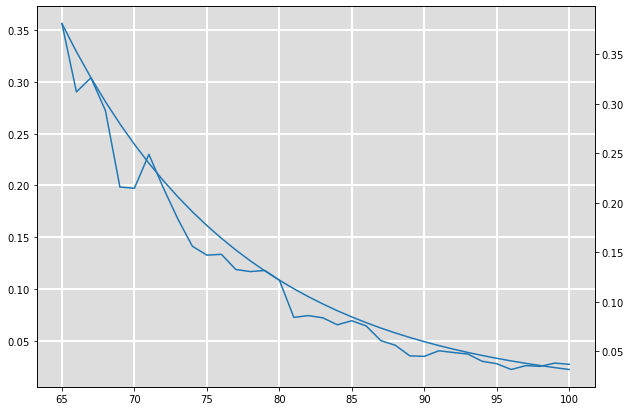

In [4]:
import numpy as np
from scipy.optimize import curve_fit


"""
Exponential fit
"""
def expo_fit(data):
    # Define exponential decay function
    # f(x) must be zero when x goes to infinity

    f = lambda x, a, c: a * np.exp(-c * (x - day))

    # Input data and fit
    xdata = np.array(data.day)
    ydata = np.array(data.rate)
    p0 = [0.1, 0.01]
    popt, pcov = curve_fit(f, xdata, ydata, p0=p0, maxfev=1000000)

    # Format regression plot
    fig2 = plt.figure(facecolor='w', figsize=(10, 7))
    ax = fig2.add_subplot(111, axisbelow=True)
    ax.set_facecolor('#dddddd')
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')

    # Plot regression
    y_pred = f(xdata, *popt)
    ax.plot(xdata, y_pred)
    ax2 = ax.twinx()
    ax2.plot(xdata, ydata)
    plt.show()
    return popt

day = 65
popt = expo_fit(sumDf[sumDf.day >= day])

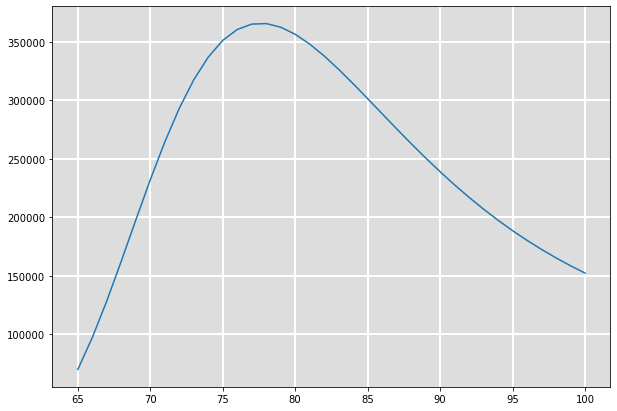

In [5]:
from scipy.integrate import quad

f_int = lambda x, a, c, const: const * np.exp(a * np.exp(-c * (x - day))) ** (x - day)
xdata = np.array(sumDf[sumDf.day >= day].day)

fig3 = plt.figure(facecolor='w', figsize=(10, 7))
ax = fig3.add_subplot(111, axisbelow=True)
ax.set_facecolor('#dddddd')
ax.grid(b=True, which='major', c='w', lw=2, ls='-')

y_pred = f_int(xdata, *popt, 70000)
ax.plot(xdata, y_pred)
#ax2 = ax.twinx()
#ax2.plot(xdata, ydata)
plt.show()


In [6]:
from scipy.integrate import quad
f = lambda x, a, c: a * np.exp(-c * (x - day))

a = quad(f(xdata, *popt), 65, 100)
a


ValueError: invalid callable given